In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score

In [2]:
os.environ['PATH'] = '../Code'
sys.path.append('../Code/NTU-FN6903-Project')

In [3]:
from utils import read_pickle, save_pickle

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
DATA_DIR = '../Data'
IMG_DIR = '../Images'

# Read Data

In [6]:
X_train_processed = pd.read_csv(os.path.join(DATA_DIR, 'X_train_processed.csv'), index_col=0)
y_train_processed = pd.read_csv(os.path.join(DATA_DIR, 'y_train_processed.csv'), index_col=0)
X_test_processed = pd.read_csv(os.path.join(DATA_DIR, 'X_test_processed.csv'), index_col=0)
y_test = pd.read_csv(os.path.join(DATA_DIR, 'y_test.csv'), index_col=0)

# Normalise Features

### Normalise numeric (non-binary) features in training set

In [7]:
NUMERIC_COLS = ['NUMDAYS', 'AGE_YRS']

In [8]:
scaler = RobustScaler()

# normalise numeric variables
X_train_numeric_scaled = scaler.fit_transform(X_train_processed[NUMERIC_COLS])
X_train_numeric_scaled = pd.DataFrame(X_train_numeric_scaled, columns=NUMERIC_COLS)

X_train_processed_scaled = pd.concat([
    X_train_numeric_scaled, 
    X_train_processed.drop(columns=NUMERIC_COLS)], axis=1)

y_train_processed = y_train_processed.to_numpy().ravel()

### Normalise numeric (non-binary) features in test set according to training set data

In [9]:
X_test_numeric_scaled = scaler.transform(X_test_processed[NUMERIC_COLS])
X_test_numeric_scaled = pd.DataFrame(X_test_numeric_scaled, columns = NUMERIC_COLS)
X_test_processed_scaled = pd.concat([
    X_test_numeric_scaled, 
    X_test_processed.reset_index(drop=True).drop(columns=NUMERIC_COLS)], axis=1)

y_test_processed = y_test.to_numpy().ravel()

# Model Fitting and Cross Validation

### Logistic Regression

In [10]:
lr_param_grid = {
'l1_ratio': np.arange(0, 1.1, 0.1), # mix between l1 and l2 regulariastion; equals alpha
'C': 1/np.array([0.1, 0.25, 0.5, 1, 2.5, 5, 10, 25, 50, 100]) # inverse regularisation strength; equals 1/lambda
}

lr_base = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=500)
lr_cv = GridSearchCV(lr_base, lr_param_grid, scoring='accuracy', refit=True, verbose=3)

#lr_cv.fit(X_train_processed_scaled, y_train_processed)
#save_pickle(lr_cv, os.path.join(DATA_DIR, 'model_lr_cv.pkl'))

### Random Forest

In [11]:
rf_param_grid = {
    'n_estimators': [500],
    'criterion': ['gini'],
    'max_features': [4, 6, 8, 11, 15, 20, 27],
    'min_weight_fraction_leaf': [0.005, 0.01, 0.025, 0.05, 0.075, 0.1]
}

rf_base = RandomForestClassifier()
rf_cv = GridSearchCV(rf_base, rf_param_grid, scoring='accuracy', refit=True, verbose=3)

#rf_cv.fit(X_train_processed, y_train_processed)
#save_pickle(rf_cv, os.path.join(DATA_DIR, 'model_rf_cv.pkl'))

### Gradient Boosting Classifier

In [12]:
gbc_param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.5, 1.0],
    "n_estimators": [32, 64, 128, 256],
    "max_features": [4, 6, 8, 11, 15, 20, 27],
    "max_depth": [2, 3, 5, 10]
}

gbc_base = GradientBoostingClassifier()
gbc_cv = GridSearchCV(gbc_base, gbc_param_grid, scoring='accuracy', refit=True, verbose=3)

#gbc_cv.fit(X_train_processed, y_train_processed)
#save_pickle(gbc_cv, os.path.join(DATA_DIR, 'model_gbc_cv.pkl'))

### Load Trained Classifiers

In [13]:
lr_cv = read_pickle(os.path.join(DATA_DIR, 'model_lr_cv.pkl'))
rf_cv = read_pickle(os.path.join(DATA_DIR, 'model_rf_cv.pkl'))
gbc_cv = read_pickle(os.path.join(DATA_DIR, 'model_gbc_cv.pkl'))

In [14]:
lr_cv.best_estimator_

LogisticRegression(C=2.0, l1_ratio=0.9, max_iter=500, penalty='elasticnet',
                   solver='saga')

In [15]:
rf_cv.best_estimator_

RandomForestClassifier(max_features=4, min_weight_fraction_leaf=0.005,
                       n_estimators=500)

In [16]:
gbc_cv.best_estimator_

GradientBoostingClassifier(learning_rate=0.05, max_features=4, n_estimators=64)

# Feature Importances

### Importance on Training Set (Coefficient Magnitude / Impurity)

In [17]:
# coefficients of logistic regression
lr_importance_df = pd.DataFrame({
    'Feature': X_train_processed_scaled.columns,
    'Importance': lr_cv.best_estimator_.coef_.ravel()
}).sort_values('Importance', ascending=True, key=np.abs)

# feature importances of random forest
rf_importance_df = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Importance': rf_cv.best_estimator_.feature_importances_.ravel()
}).sort_values('Importance', ascending=True)

# feature importances of gradient boosting classifier
gbc_importance_df = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Importance': gbc_cv.best_estimator_.feature_importances_.ravel()
}).sort_values('Importance', ascending=True)

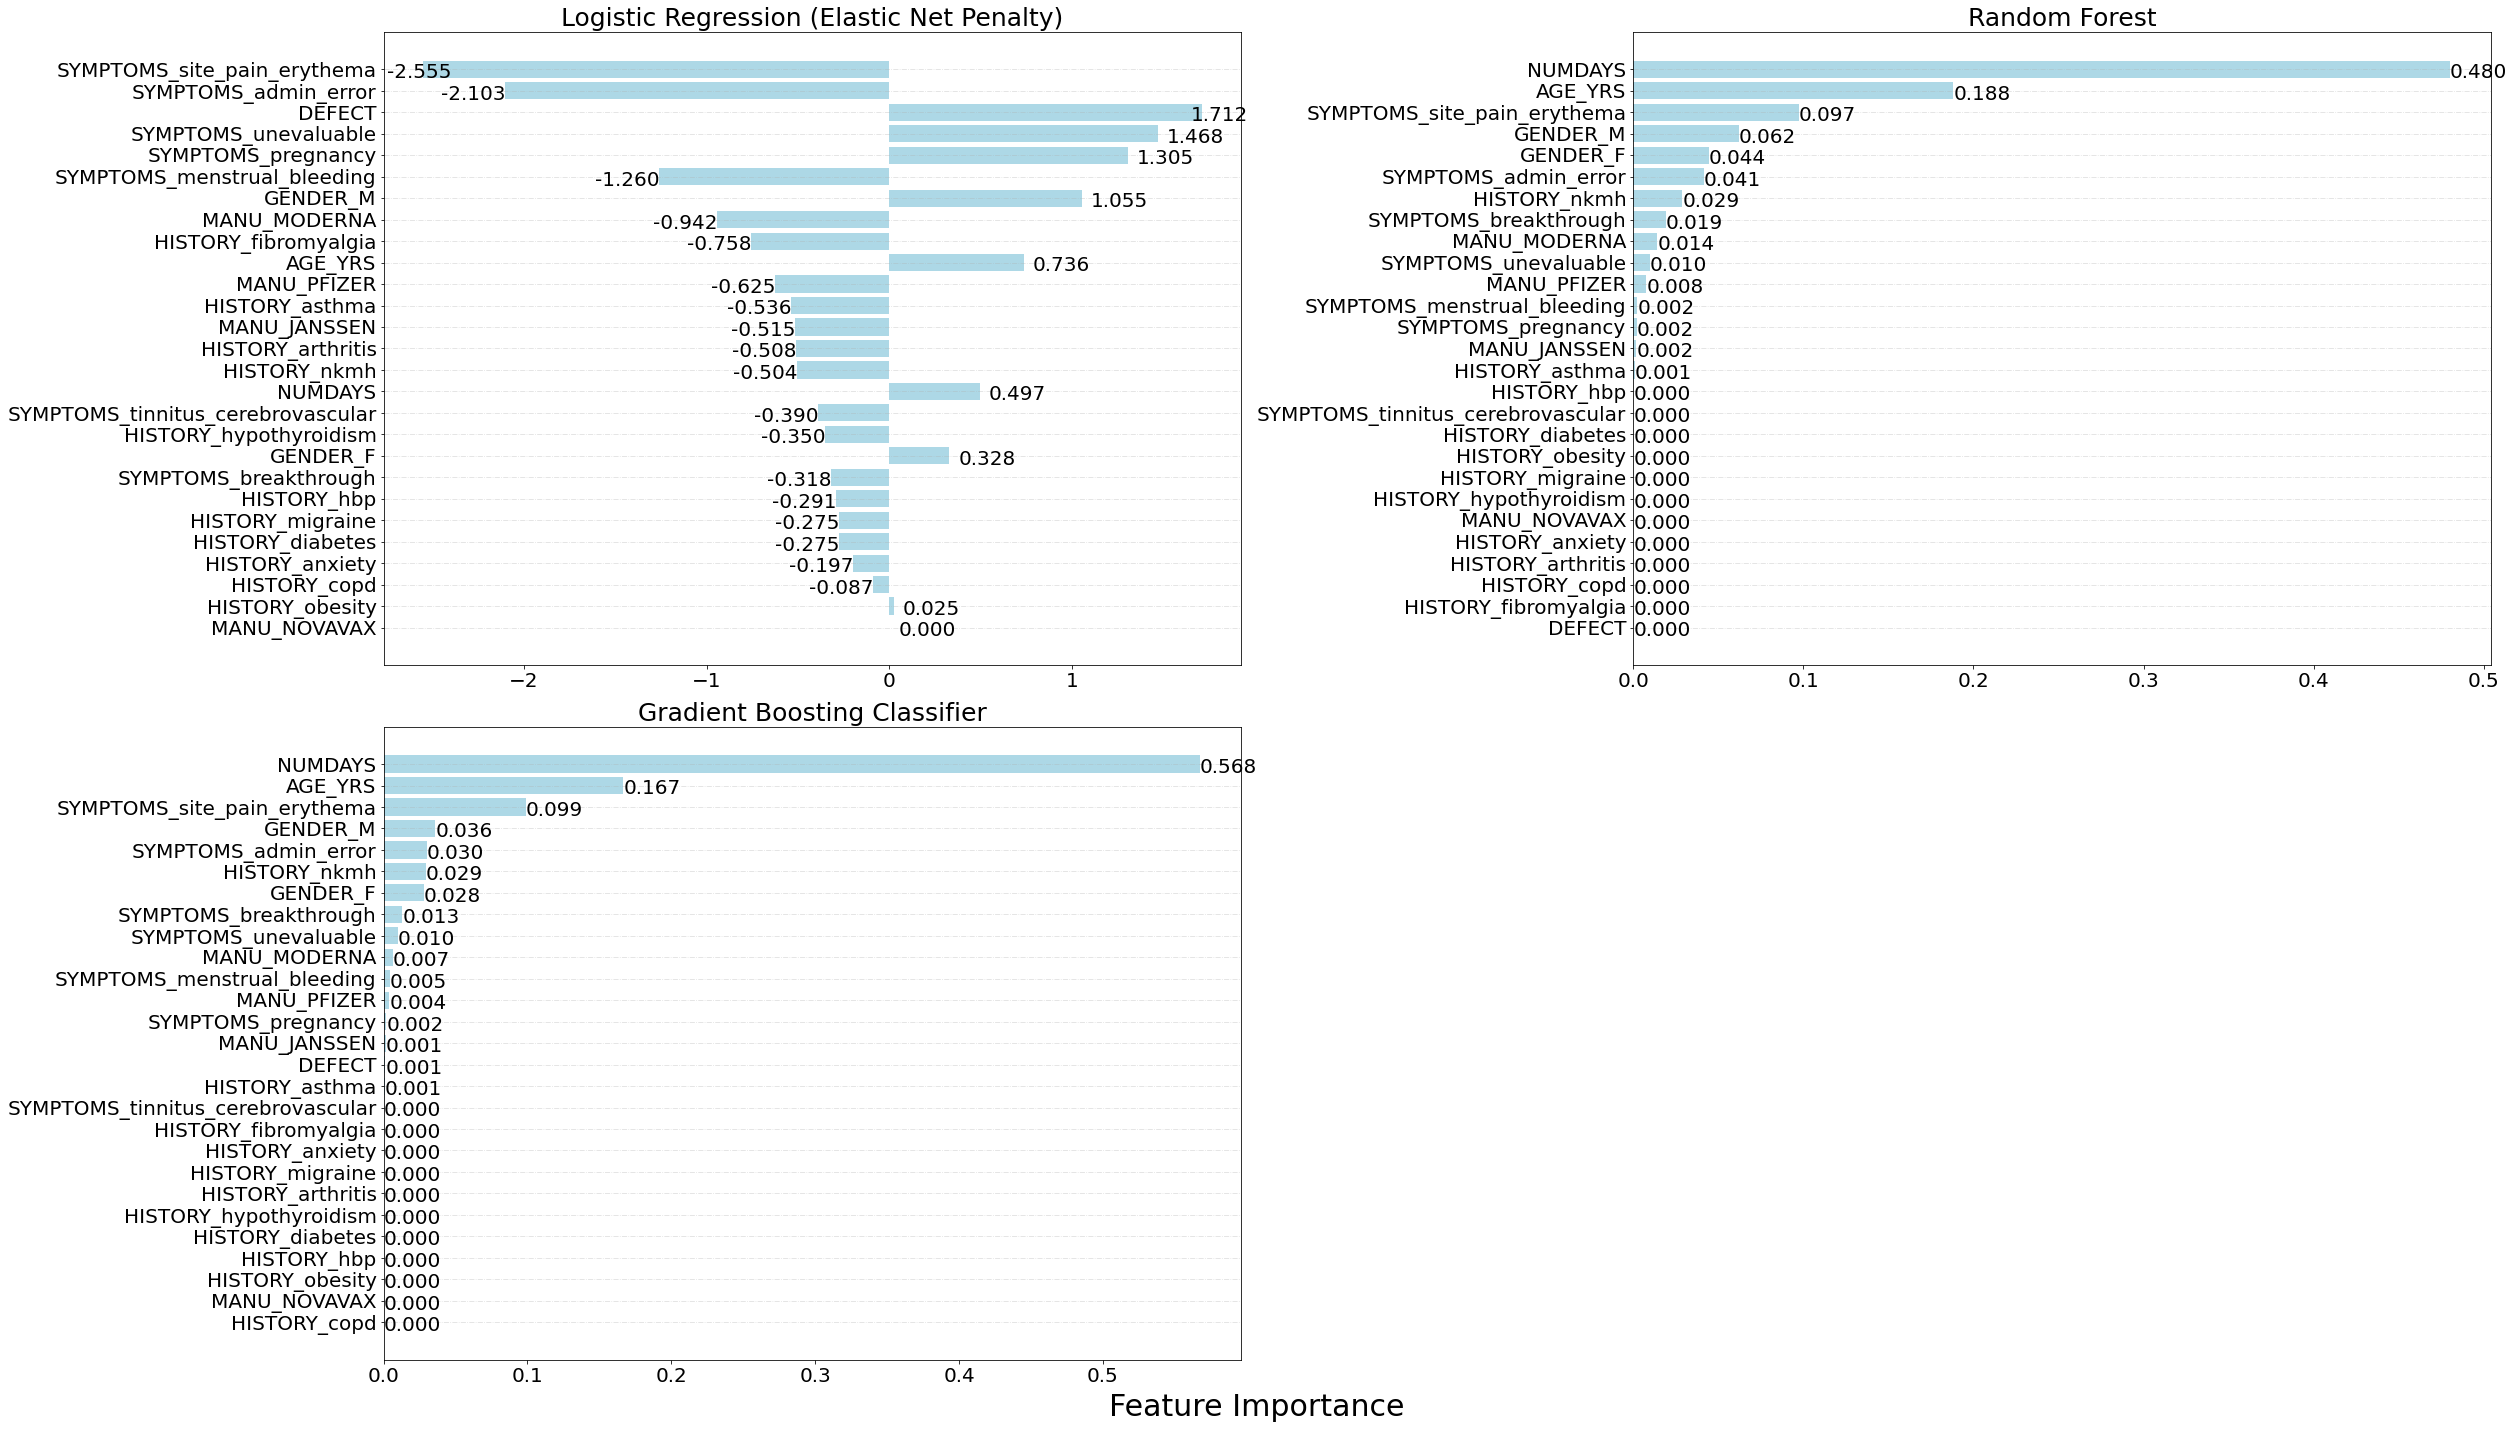

In [18]:
importance_dict = {
    0: (lr_importance_df, 'Logistic Regression (Elastic Net Penalty)', (0,0)),
    1: (rf_importance_df, 'Random Forest', (0,1)),
    2: (gbc_importance_df, 'Gradient Boosting Classifier', (1,0))
}

fig, axes = plt.subplots(2,2, figsize=(35,20))
for i in range(3):
    ax = axes[importance_dict[i][2]]
    rects = ax.barh(importance_dict[i][0]['Feature'], importance_dict[i][0]['Importance'], color='lightblue')
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.grid(linestyle="-.", axis='y', alpha=0.4)
    
    for j, rect in enumerate(rects):
        width = rect.get_width()
        ax.text(
            width+int(i==0 and width<0)*(max(-2.75, width-0.35)-width)+int(i==0 and width>=0)*(min(1.65, width+0.05)-width), 
            rect.get_y()+0.25,
            '%.3f' % width, 
            ha='left', 
            va='center', 
            fontsize=20
        )
    ax.set_title(importance_dict[i][1], fontsize=25)

fig.supxlabel('Feature Importance', fontsize=30)
fig.tight_layout()
fig.delaxes(axes[(1,1)])
plt.savefig(os.path.join(IMG_DIR, 'feat_impt_train.pdf'), bbox_inches='tight')
plt.show()

### Permutation Importance on Test Set

In [19]:
# feature importances of logistic regression
#lr_importance_perm_df = pd.DataFrame({
#    'Feature': X_train_processed_scaled.columns,
#    'Importance': permutation_importance(
#        lr_cv.best_estimator_, 
#        X_test_processed_scaled, 
#        y_test_processed, 
#        n_repeats=30, 
#        random_state=55
#    )['importances_mean']
#}).sort_values('Importance', ascending=True, key=np.abs)

# feature importances of random forest
#rf_importance_perm_df = pd.DataFrame({
#    'Feature': X_train_processed.columns,
#    'Importance': permutation_importance(
#        rf_cv.best_estimator_, 
#        X_test_processed, 
#        y_test_processed, 
#        n_repeats=30, 
#        random_state=55
#    )['importances_mean']
#}).sort_values('Importance', ascending=True)

# feature importances of gradient boosting classifier
#gbc_importance_perm_df = pd.DataFrame({
#    'Feature': X_train_processed.columns,
#    'Importance': permutation_importance(
#        gbc_cv.best_estimator_, 
#        X_test_processed, 
#        y_test_processed, 
#        n_repeats=30, 
#        random_state=55
#    )['importances_mean']
#}).sort_values('Importance', ascending=True)

In [20]:
#save_pickle(lr_importance_perm_df, os.path.join(DATA_DIR, 'lr_importance_perm_df.pkl'))
#save_pickle(rf_importance_perm_df, os.path.join(DATA_DIR, 'rf_importance_perm_df.pkl'))
#save_pickle(gbc_importance_perm_df, os.path.join(DATA_DIR, 'gbc_importance_perm_df.pkl'))

In [21]:
lr_importance_perm_df = read_pickle(os.path.join(DATA_DIR, 'lr_importance_perm_df.pkl'))
rf_importance_perm_df = read_pickle(os.path.join(DATA_DIR, 'rf_importance_perm_df.pkl'))
gbc_importance_perm_df = read_pickle(os.path.join(DATA_DIR, 'gbc_importance_perm_df.pkl'))

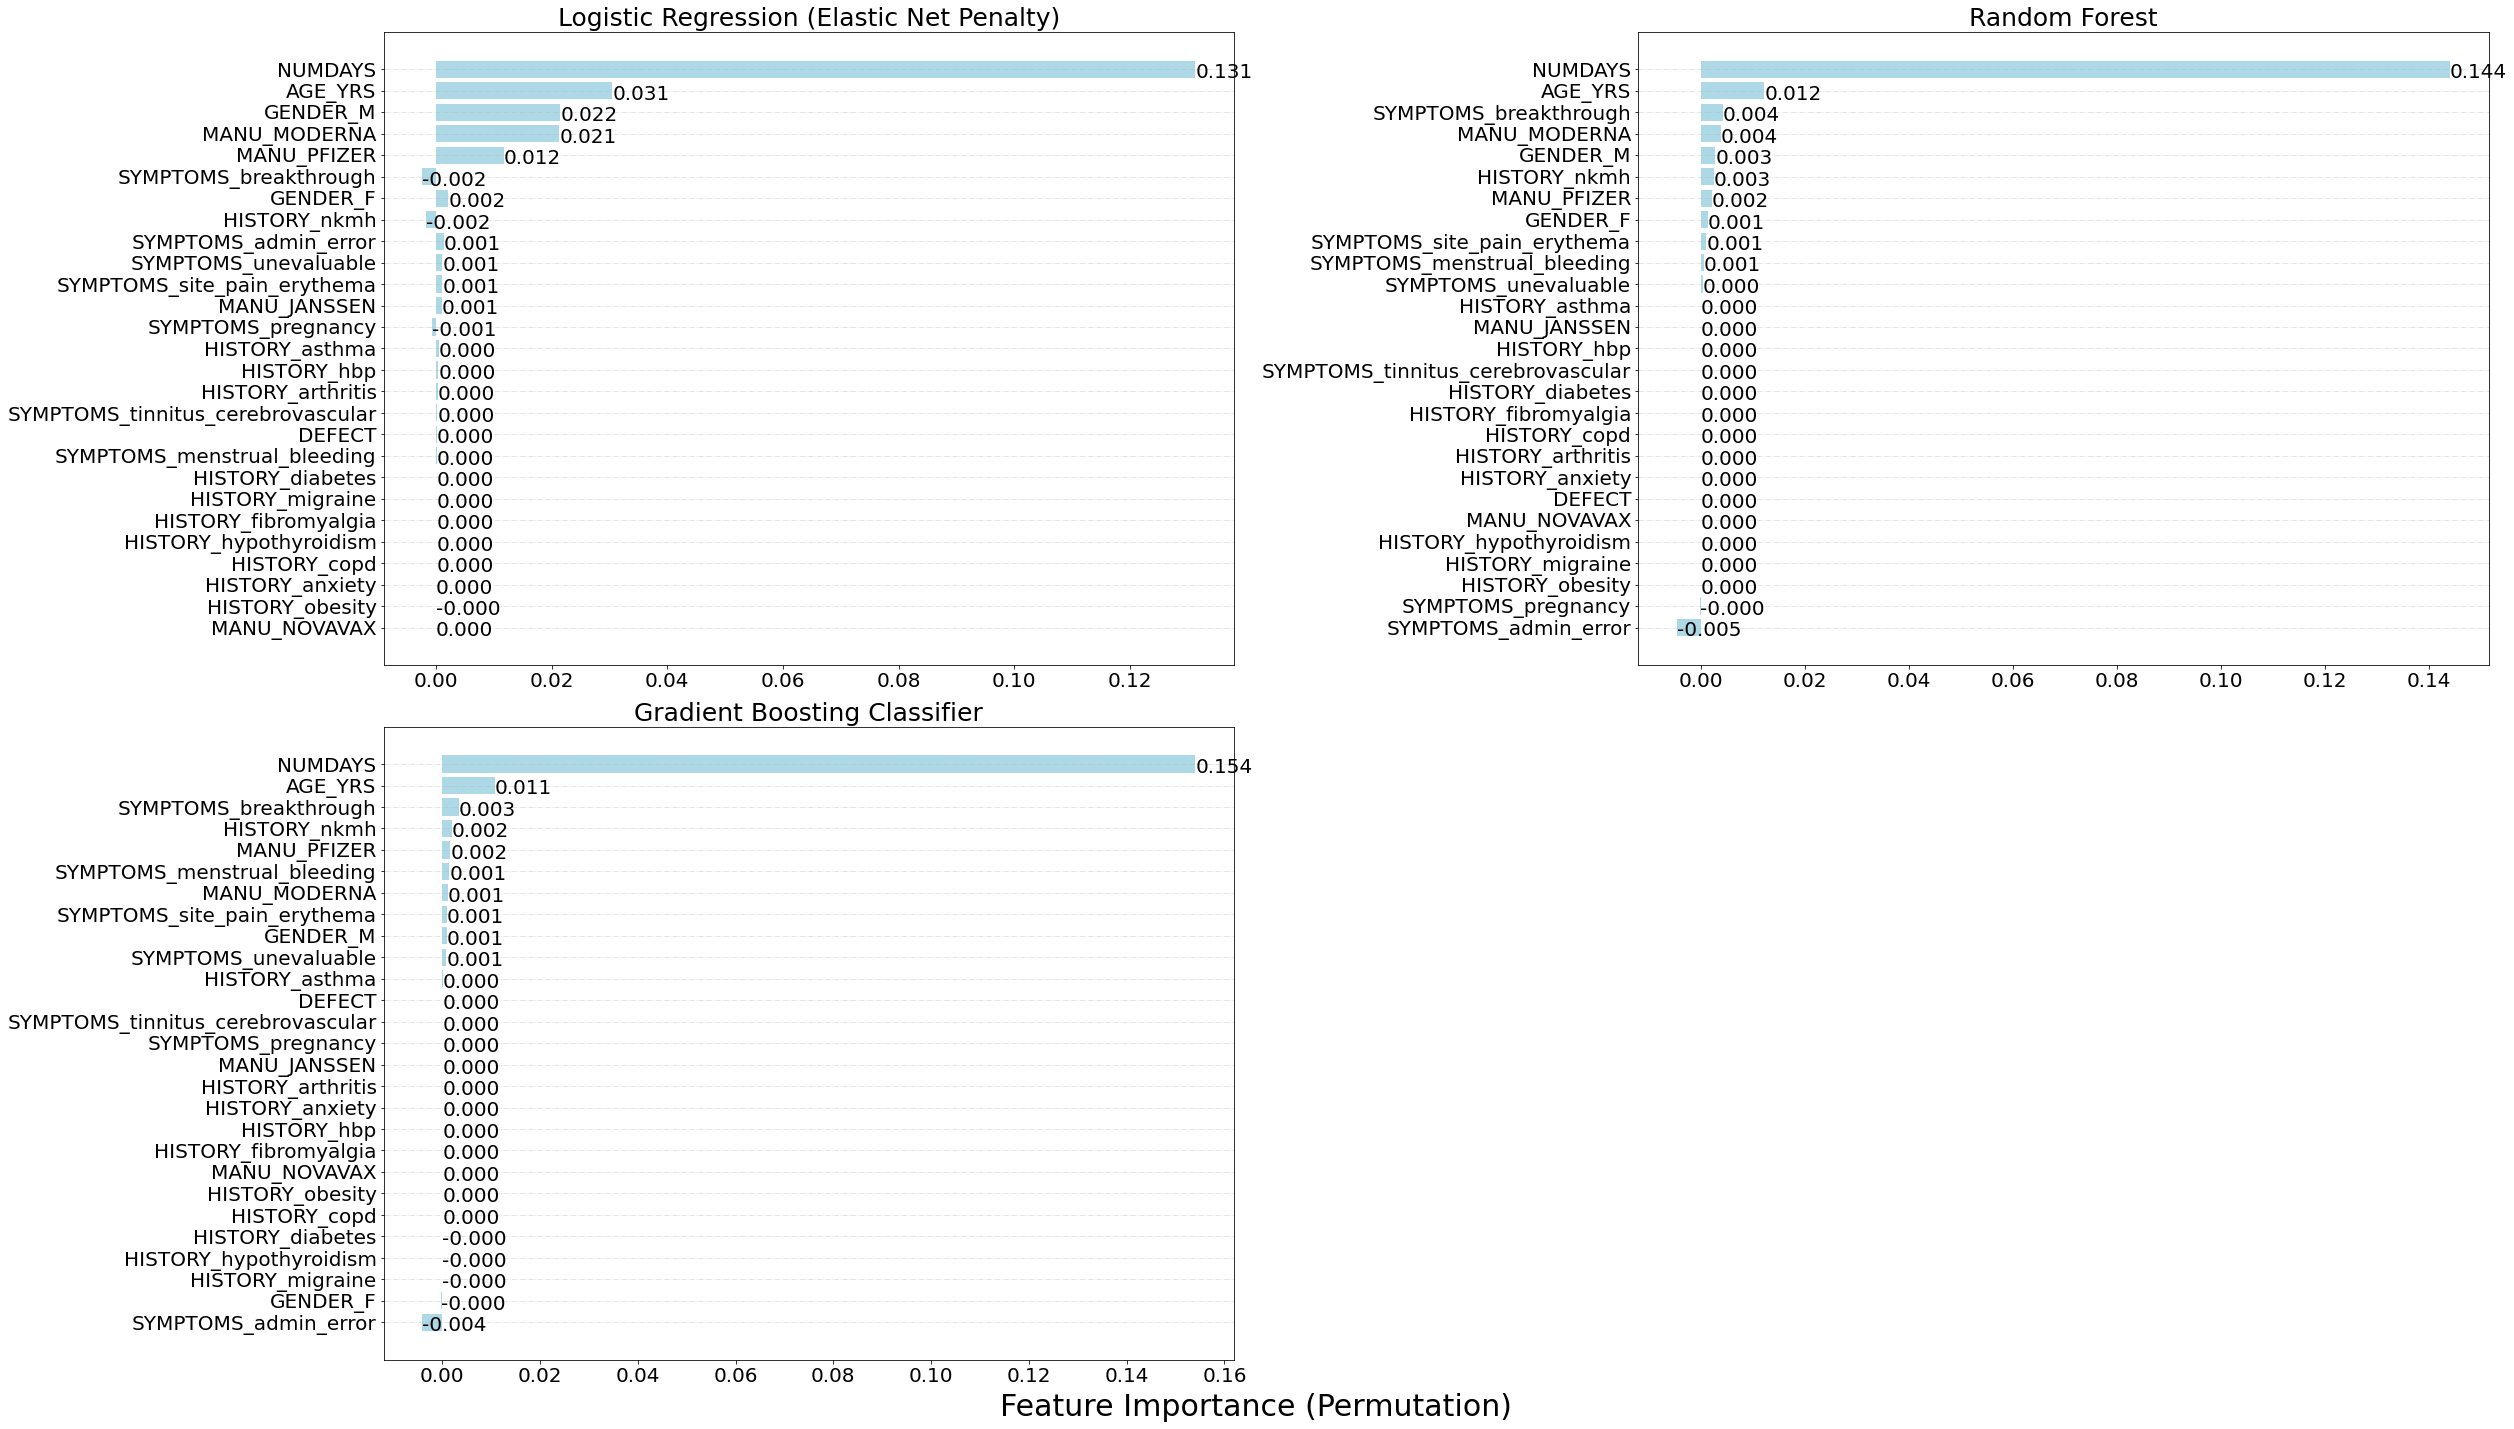

In [22]:
importance_perm_dict = {
    0: (lr_importance_perm_df, 'Logistic Regression (Elastic Net Penalty)', (0,0)),
    1: (rf_importance_perm_df, 'Random Forest', (0,1)),
    2: (gbc_importance_perm_df, 'Gradient Boosting Classifier', (1,0))
}

fig, axes = plt.subplots(2,2, figsize=(35,20))
for i in range(3):
    ax = axes[importance_perm_dict[i][2]]
    rects = ax.barh(importance_perm_dict[i][0]['Feature'], importance_perm_dict[i][0]['Importance'], color='lightblue')
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.grid(linestyle="-.", axis='y', alpha=0.4)
    
    for j, rect in enumerate(rects):
        width = rect.get_width()
        ax.text(
            width, 
            rect.get_y()+0.25,
            '%.3f' % width, 
            ha='left', 
            va='center', 
            fontsize=20
        )
    ax.set_title(importance_dict[i][1], fontsize=25)

fig.supxlabel('Feature Importance (Permutation)', fontsize=30)
fig.tight_layout()
fig.delaxes(axes[(1,1)])
plt.savefig(os.path.join(IMG_DIR, 'feat_impt_test.pdf'), bbox_inches='tight')
plt.show()

# Validate Model Performances

### Compute Predictions on Training and Test Set

In [23]:
y_pred = {
    'Baseline': {
        'Train': np.zeros(y_train_processed.shape[0]),
        'Test': np.zeros(y_test_processed.shape[0]),
    },
    'Logistic Regression (Elastic Net Penalty)': {
        'Train': lr_cv.predict(X_train_processed_scaled),
        'Test': lr_cv.predict(X_test_processed_scaled),
    },
    'Random Forest': {
        'Train': rf_cv.predict(X_train_processed),
        'Test': rf_cv.predict(X_test_processed),
    },
    'Gradient Boosting Classifier': {
        'Train': gbc_cv.predict(X_train_processed),
        'Test': gbc_cv.predict(X_test_processed)
    }
}

In [24]:
performance_df_lst = []
for model in y_pred:
    performance_df_lst.append(pd.DataFrame({
        'Model': [model],
        'Accuracy (Train)': [accuracy_score(y_train_processed, y_pred[model]['Train'])],
        'Precision (Train)': [precision_score(y_train_processed, y_pred[model]['Train'])],
        'Recall (Train)': [recall_score(y_train_processed, y_pred[model]['Train'])],
        'Balanced Accuracy (Train)': [balanced_accuracy_score(y_train_processed, y_pred[model]['Train'])],
        'Accuracy (Test)': [accuracy_score(y_test_processed, y_pred[model]['Test'])],
        'Precision (Test)': [precision_score(y_test_processed, y_pred[model]['Test'])],
        'Recall (Test)': [recall_score(y_test_processed, y_pred[model]['Test'])],
        'Balanced Accuracy (Test)': [balanced_accuracy_score(y_test_processed, y_pred[model]['Test'])],
    }))
    
performance_df = pd.concat(performance_df_lst, ignore_index=True).T
performance_df.rename(columns=performance_df.iloc[0], inplace=True)
performance_df.drop(performance_df.index[0], inplace=True)

np.round(performance_df,3)

/Users/matthewngchengen/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matthewngchengen/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Baseline,Logistic Regression (Elastic Net Penalty),Random Forest,Gradient Boosting Classifier
Accuracy (Train),0.5,0.746649,0.782656,0.782471
Precision (Train),0.0,0.767993,0.785142,0.785324
Recall (Train),0.0,0.706828,0.778296,0.777472
Balanced Accuracy (Train),0.5,0.746649,0.782656,0.782471
Accuracy (Test),0.765984,0.716537,0.725447,0.725887
Precision (Test),0.0,0.449204,0.458772,0.459172
Recall (Test),0.0,0.934287,0.963808,0.963524
Balanced Accuracy (Test),0.5,0.79215,0.808216,0.808405
